In [1]:
import pennylane as qml
from pennylane import numpy as np
import qemzmsepc as qem

Cost after step     5:  0.7838255
Cost after step    10:  0.3490388
Cost after step    15:  0.2277100
Cost after step    20:  0.1111908
Cost after step    25:  0.1416155
Cost after step    30:  0.1301306
Cost after step    35:  0.0849585
Cost after step    40:  0.0820515
Cost after step    45:  0.0405958
Cost after step    50:  0.0561945
Cost after step    55:  0.1421452
Cost after step    60:  0.0501103
Cost after step    65:  0.0497063
Cost after step    70:  0.0190227
Cost after step    75:  0.0326289
Cost after step    80:  0.0372995
Cost after step    85:  0.0806038
Cost after step    90:  0.0133889
Cost after step    95:  0.0412872
Cost after step   100:  0.1081051
Optimized rotation angles: [[[ 0.65257407  1.48342065  0.04350088]
  [ 0.6313857   0.92465116  0.39317687]]

 [[-0.38663961  2.21668355  0.68214353]
  [ 0.73627523  0.53487058  0.04868588]]]


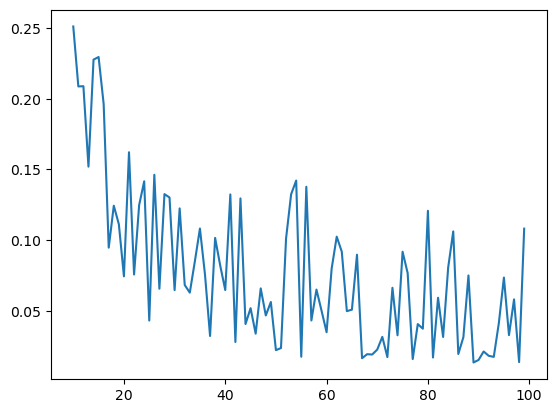

In [2]:
# we introduced noise into the network and trained it without any error mitigation techniques
# to observe the behavior of the Loss function degradation during training.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

# When simulating a complex scenario of time-varying noise channels,
# it can be observed that the descent of the Loss function is relatively unstable
# in the absence of error mitigation techniques.

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

Cost after step     5:  0.5324833
Cost after step    10:  0.2051506
Cost after step    15:  0.1290284
Cost after step    20:  0.1012894
Cost after step    25:  0.0882278
Cost after step    30:  0.0810872
Cost after step    35:  0.0767914
Cost after step    40:  0.0740318
Cost after step    45:  0.0721744
Cost after step    50:  0.0708811
Cost after step    55:  0.0699577
Cost after step    60:  0.0692861
Cost after step    65:  0.0687908
Cost after step    70:  0.0684216
Cost after step    75:  0.0681443
Cost after step    80:  0.0679348
Cost after step    85:  0.0677758
Cost after step    90:  0.0676546
Cost after step    95:  0.0675621
Cost after step   100:  0.0674913
Optimized rotation angles: [[[ 0.12054601  1.53525729  0.02328143]
  [ 0.11744949  2.18129417  0.11108782]]

 [[-0.10769611  0.96009608  0.22584841]
  [ 0.95719209  0.03378759  0.77047987]]]


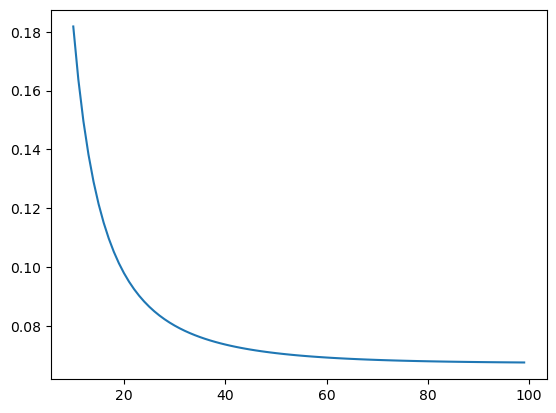

In [3]:
# We set the noise channel as time-invariant and observe the results again.

n_qubits = 2
dev = qml.device('default.mixed', wires=n_qubits)

nqubitschannel = qem.NqubitsChannel(n_qubits)
nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
nqubitsdepolarizingchannel = nqubitschannel.nqubitsdepolarizingchannel(0.9)

@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_without_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

def cost(x):
    return (train_cir_without_qem(x) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []

for i in range(steps):
    params = opt.step(cost, params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))

import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [4]:
# We estimate the total noise 'p_t' using the QEMZMSEPC method,
# allowing us to incorporate noise 'p_t' into the definition of the Loss function,
# thereby mitigating the impact of noise on quantum machine learning tasks.

operations = ['RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT',
              'RX', 'RY', 'RZ', 'RX', 'RY', 'RZ', 'CNOT', 'CNOT']
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)
w = weights.copy().reshape(-1)
paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
     [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
qemzmsepc = qem.QEMZMSEPC(n_qubits)
_, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                         kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
print(p_t)

0.740660543670812


Cost after step     5:  0.2501352
Cost after step    10:  0.0592016
Cost after step    15:  0.0252419
Cost after step    20:  0.0139921
Cost after step    25:  0.0089336
Cost after step    30:  0.0062241
Cost after step    35:  0.0045999
Cost after step    40:  0.0035469
Cost after step    45:  0.0028239
Cost after step    50:  0.0023050
Cost after step    55:  0.0019194
Cost after step    60:  0.0016247
Cost after step    65:  0.0013941
Cost after step    70:  0.0012102
Cost after step    75:  0.0010611
Cost after step    80:  0.0009383
Cost after step    85:  0.0008361
Cost after step    90:  0.0007499
Cost after step    95:  0.0006766
Cost after step   100:  0.0006137
Optimized rotation angles: [[[ 0.87661208  1.34419848  0.0135945 ]
  [ 0.64010722  1.8725403  -0.2673313 ]]

 [[ 0.31654157  1.2348347   0.83412442]
  [ 0.97070916  0.12902109  0.68363993]]]


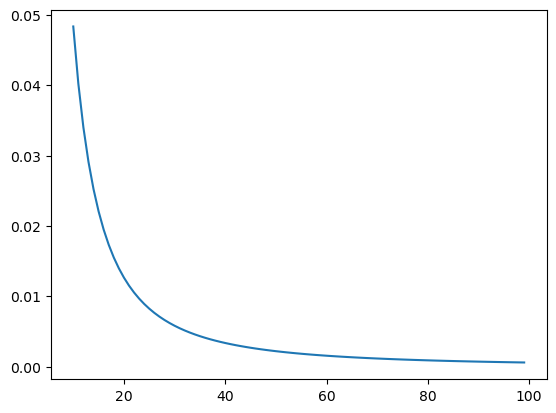

In [5]:
@qml.qnode(qml.device('default.mixed', wires=n_qubits))
def train_cir_with_qem(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(2))
    qml.QubitChannel(nqubitsdepolarizingchannel, wires=[0, 1])
    qml.QubitChannel(nqubitspaulichannel, wires=[0, 1])
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
weights = np.random.random(size=shape)

# We modify the definition of the Loss function
# by dividing the output of the quantum circuit by the noise parameter p_t
# to obtain the expected output of the quantum circuit after error mitigation,
# and then proceed with the Loss calculation.

def cost(x):
    return ((train_cir_with_qem(x) / p_t) - (-1)) ** 2

opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params = weights
loss = []
qemzmsepc = qem.QEMZMSEPC(n_qubits)

for i in range(steps):
    params = opt.step(cost, params)
    w = params.copy().reshape(-1)
    paras = [[0, w[0]], [0, w[1]], [0, w[2]], [0, w[3]], [0, w[4]], [0, w[5]], [0, 1], [1, 0],
         [0, w[6]], [0, w[7]], [0, w[8]], [0, w[9]], [0, w[10]], [0, w[11]], [0, 1], [1, 0]]
    nqubitspaulichannel = nqubitschannel.nqubitsrandompaulichannel(p_identity=0.85)
    _, p_t = qemzmsepc.qemzmsepc(operations=operations, paras=paras, dev=dev, p=0.9,
                             kraus_matrices_of_a_pauli_channel=nqubitspaulichannel)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    loss.append(cost(params))
print("Optimized rotation angles: {}".format(params))
import matplotlib.pyplot as plt
x = [i for i in range(10, 100)]
y = loss[10:]
plt.plot(x, y)
plt.show()

In [6]:
# From the results, we can observe that the Loss function exhibits a stable decreasing trend
# after error mitigation through the QEMZMSEPC scheme,
# and ultimately, the outcome is better than without error mitigation.